In [1]:
import re
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt

class CatDataset(Dataset):
    def __init__(self, image_path, transform=None, is_train=True):
        self.paths = []
        self.labels = []
        for w, _, files in os.walk(image_path):
            for f in files:
                if f.endswith('.jpg') or f.endswith('.png') or f.endswith('.jpeg'):
                    self.paths.append(os.path.join(w, f))
                    # 1是有耄耋面相，0不是耄耋
                    self.labels.append(int(re.findall(r'\d+', f.split('-')[-1])[0]))
        self.transform = transform
        self.is_train = is_train

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        # 读取图像
        image = Image.open(self.paths[idx]).convert('RGB')

        # 应用数据增强
        if self.transform:
            image = self.transform(image)

        return image, self.labels[idx]


train_transform = transforms.Compose([
    # 调整图像大小
    transforms.Resize((224, 224)),
    # 随机水平翻转
    transforms.RandomHorizontalFlip(p=0.5),
    # 随机旋转左右90度
    transforms.RandomRotation(degrees=90),
    # 随机调节亮度、对比度、饱和度和色相
    transforms.ColorJitter(
        brightness=0.2,
        contrast=0.2,
        saturation=0.2,
        hue=0.1
    ),
    transforms.ToTensor(),

    # 三通道标准化，来自imagenet
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


In [2]:
draw = False

image_path = './dataset/maodie'

train_dataset = CatDataset(
    image_path=image_path,
    transform=transforms.Compose(train_transform.transforms[:-1]) if draw else train_transform,
    is_train=True
)

val_dataset = CatDataset(
    image_path=image_path,
    transform=val_transform,
    is_train=False
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False
)

if draw:
    for images, labels in train_loader:
        img = np.asarray(images[0])
        plt.imshow(img.transpose((1, 2, 0)))
        plt.show()
        break

In [3]:
import torch
from torch import nn
from torch.nn import functional as F


class Residual(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            # 第一层进来做1*1卷积，因为特征已经被降了很多
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X # res
        return F.relu(Y)

# 3通道输入，64通道输出，7*7配合3padding输入形状不变，stride为2高宽砍半
b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))


In [4]:
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

b2 = resnet_block(64, 64, 2, True)
b3 = resnet_block(64, 128, 2)
b4 = resnet_block(128, 256, 2)
b5 = resnet_block(256, 512, 2)

res_net = nn.Sequential(b1, nn.Sequential(*b2), nn.Sequential(*b3), nn.Sequential(*b4), nn.Sequential(*b5),
                        # 自适应卷积，前两维1*1
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 2))
# for k, _ in res_net.state_dict().items():
#     print(k)

In [5]:
# X_ = torch.rand(size=(1, 3, 224, 224))
#
# # 这一步演示钩子函数
# def size_observe_hook(module, _, output_t):
#     print(module.__class__.__name__, 'output shape:\t', output_t.shape)
#
# # 这一步将每个module都带上观察输出的函数
# def size_observe_attach_with_weight_init(net: nn.Sequential):
#     # 线性曾用xavier初始化权重
#     for m in net:
#         if isinstance(m, nn.Sequential):
#             size_observe_attach_with_weight_init(m)
#         elif isinstance(m, nn.Linear):
#             # 这一步演示用xavier正则分布初始化线性层权重
#             torch.nn.init.xavier_uniform_(m.weight)
#             m.bias.data.fill_(0.01)
#             m.register_forward_hook(size_observe_hook)
#         else:
#             m.register_forward_hook(size_observe_hook)
#
# size_observe_attach_with_weight_init(res_net)
#
# y_ = res_net(X_)
#
for name, module in res_net.named_modules():
    print(name)
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")



0
0.0
0.1
0.2
0.3
1
1.0
1.0.conv1
1.0.conv2
1.0.bn1
1.0.bn2
1.1
1.1.conv1
1.1.conv2
1.1.bn1
1.1.bn2
2
2.0
2.0.conv1
2.0.conv2
2.0.conv3
2.0.bn1
2.0.bn2
2.1
2.1.conv1
2.1.conv2
2.1.bn1
2.1.bn2
3
3.0
3.0.conv1
3.0.conv2
3.0.conv3
3.0.bn1
3.0.bn2
3.1
3.1.conv1
3.1.conv2
3.1.bn1
3.1.bn2
4
4.0
4.0.conv1
4.0.conv2
4.0.conv3
4.0.bn1
4.0.bn2
4.1
4.1.conv1
4.1.conv2
4.1.bn1
4.1.bn2
5
6
7


In [ ]:
import time
from visualization.loss_graph import Animator

def to_float(x):
    if isinstance(x, torch.Tensor):
        return x.detach().cpu().item() if x.numel() == 1 else x.detach().cpu().numpy()
    return float(x)

res_net = res_net.to(device)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(res_net.parameters(), lr=0.001)

batch_size = 32
epochs = 50

animator = Animator(xlabel='epoch', ylabel='loss/accuracy', legend=['train acc', 'test acc', 'loss'])

for epoch in range(epochs):
    res_net.train()
    total_loss, total_acc, count = 0, 0, 0
    # 训练总损失、训练精度、训练经过的样本数
    start_time = time.time()
    for X, y in train_loader:
        X = X.to('mps')
        y = y.to('mps')
        y_hat = res_net(X)

        l = loss(y_hat, y)
        total_loss += l
        optimizer.zero_grad()
        l.backward()
        optimizer.step()


        total_loss += l.item() * X.size(0)
        total_acc += (y_hat.argmax(dim=1) == y).sum().item()
        count += X.size(0)
    train_loss = total_loss / count
    train_acc = total_acc / count

    res_net.eval()
    test_acc, test_count = 0, 0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to('mps'), y.to('mps')
            test_acc += (res_net(X).argmax(dim=1) == y).sum().item()
            test_count += X.size(0)
    test_acc /= test_count

    # 更新图像
    animator.add(epoch + 1, (to_float(train_acc), to_float(test_acc), to_float(train_loss)))
    print(f"Epoch {epoch+1}: train_acc={train_acc:.3f}, test_acc={test_acc:.3f}, train_loss={train_loss:.3f}, time={time.time()-start_time:.1f}s")


plt.ioff()
display(animator.fig)
plt.show()



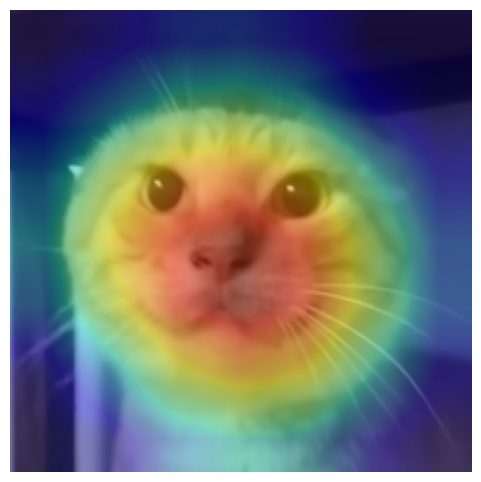

In [7]:
draw_iterator = DataLoader(val_dataset, batch_size=1, shuffle=True) # 就拿一个，（1，224，224）
target_layer = '4.1.conv2'
res_net.load_state_dict(torch.load("res_net.pth"))
res_net = res_net.to(device)

def inverse_transform(tensor):
    """
    将标准化后的张量转换回 PIL 图像
    :param tensor: (3, 224, 224)
    """
    tensor = tensor.clone()

    # 先乘以标准差，再加上均值
    mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)  # (3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
    tensor = tensor * std + mean
    # 将张量值限制在[0,1]范围内，防止后面乘255出问题（应该也不会出问题
    tensor = torch.clamp(tensor, 0, 1)

    tensor = tensor.permute(1, 2, 0)  #从chw转为hwc
    numpy_image = tensor.numpy()

    # 反归一化
    numpy_image = (numpy_image * 255).astype(np.uint8)
    return Image.fromarray(numpy_image)


class GradCAM:
    def __init__(self, model: torch.nn.Module, target_layer: str):
        self.model = model
        self.model.eval()
        self.target_layer = target_layer

        # 存储梯度和这一层输出的特征图
        self.activations = None
        self.gradients = None

        # 注册hook
        for name, module in self.model.named_modules():
            if name == target_layer:
                module.register_forward_hook(self._forward_hook)
                module.register_backward_hook(self._backward_hook)
                break
        else:
            raise ValueError(f"Couldn't find layer '{target_layer}' in the model")

    def _forward_hook(self, _, __, output):
        self.activations = output.detach() # (1, c, h, w)

    def _backward_hook(self, _, __, output):
        # 这个output还套一个元组里
        self.gradients = output[0].detach() # (1, c, h, w)

    def generate_cam(self, input_tensor: torch.Tensor, target_class: int, upsample_size=(224, 224)):
        predict = self.model(input_tensor)
        one_hot = torch.zeros_like(predict)
        # 这个onehot编码的向量放进反向传播里面去算这一类关于最后一层卷积的梯度
        one_hot[0, target_class] = 1  # [[0, 1]]

        predict.backward(gradient=one_hot)

        activations = self.activations[0]
        gradients = self.gradients[0] # (c, h, w), (512, 7, 7)

        avg = gradients.mean(dim=[1, 2], keepdim=False) # (c)

        cam = torch.zeros(activations.shape[1:], dtype=activations.dtype, device=device) # (h, w)
        for k, w in enumerate(avg):
            cam += w * activations[k]

        # 说只要正提梯度
        cam = F.relu(cam)

        # 上采样到输入尺寸
        if upsample_size is not None:
            cam = cam.unsqueeze(0).unsqueeze(0)  # (1,1,h,w)
            cam = F.interpolate(cam, size=upsample_size, mode='bilinear', align_corners=False)
            # 前2维当批量和通道用
            cam = cam[0, 0]

        # 归一化到 [0,1]
        cam -= cam.min()
        if cam.max() != 0:
            cam /= (cam.max() + 1e-8)

        return cam.cpu().numpy()


gradcam = GradCAM(res_net, target_layer)

for X, l in draw_iterator:
    X = X.to(device)
    l = l.to(device)
    pix = X[0].cpu()
    draw_t = inverse_transform(pix)
    cam = gradcam.generate_cam(X, 1)
    plt.figure(figsize=(6,6))
    plt.imshow(draw_t)
    # 热力图叠上去
    plt.imshow(cam, cmap='jet', alpha=0.4)
    plt.axis('off')
    plt.show()
    break


In [11]:
# 保存模型参数
torch.save(res_net.state_dict(), "res_net.pth")

# 读取模型参数
new_model = nn.Sequential(b1, nn.Sequential(*b2), nn.Sequential(*b3), nn.Sequential(*b4), nn.Sequential(*b5),
                        # 自适应卷积，前两维1*1
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 2))
new_model.load_state_dict(torch.load("res_net.pth"))

<All keys matched successfully>